## Imports

In [1]:
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, EarlyStopping, LRScheduler

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt

import numpy as np

import os

from src.models.TurbulenceNetwork import TurbulenceNetwork
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Device: ", device)

%load_ext autoreload
%autoreload 2


Device:  cuda:0


## Misc Utilities

In [2]:
class MAPELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MAPELoss, self).__init__()
        self.eta = 1e-9

    def forward(self, y_pred, y_true):
        l = torch.abs((y_true - y_pred)) / (torch.abs(y_true) + self.eta)

        return torch.mean(l)

class RMSELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(RMSELoss, self).__init__()
        self.eta = 1e-8

    def forward(self, y_pred, y_true):
        l = torch.sqrt(torch.mean(torch.pow((y_true - y_pred), 2)))

        return l


## Data Generation

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:88: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


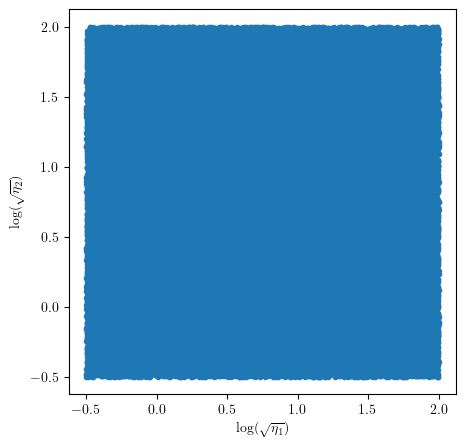

In [3]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="All")

etas_test, gs_test = generate_log_data(SSG_gen, log, 40_000, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)


In [14]:
x_scaler = CustomScalerX().fit(etas_train)
y_scaler = CustomScalerY().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_train = torch.tensor(x_scaled_train, dtype=torch.float32)
y_train = torch.tensor(y_scaled_train, dtype=torch.float32)

x_test = torch.tensor(x_scaler.transform(etas_test), dtype=torch.float32)
y_test = torch.tensor(y_scaler.transform(gs_test), dtype=torch.float32)

x_vis = np.loadtxt("data/Input/vis_etas.csv", delimiter=",")
y_vis = np.loadtxt("data/Input/vis_gs.csv", delimiter=",")

x_vis = torch.tensor(x_scaler.transform(x_vis), dtype=torch.float32)
y_vis = torch.tensor(y_scaler.transform(y_vis), dtype=torch.float32)


## Network Training

In [5]:
# Defining model parameters
checkpoint_dir = './Model_Checkpoints/ensemble/'


net_params = {
        "input_dim": 2,
        "output_dim": 3,
        "num_layers": 4,
        "h_dim": 20,
}

train_params = {
        "criterion": nn.MSELoss,
        "optimizer": torch.optim.Adam,
        "optimizer__weight_decay": 1e-6,
        "lr": 0.001,
        "batch_size": 64,
        "max_epochs": 100,
        "device": device,
        "iterator_train__shuffle": True,
        "iterator_train__num_workers": 4,
        "iterator_train__pin_memory": True,
        "iterator_valid__shuffle": False,
        "iterator_valid__num_workers": 4,
        "iterator_valid__pin_memory": True,
        "verbose": 0,
}

num_members = 20

In [6]:
test_criteria = RMSELoss()


for i in range(num_members):
        callbacks = [EarlyStopping(patience=15, threshold=0.00005, threshold_mode='abs', monitor='valid_loss', lower_is_better=True),
                Checkpoint(monitor='valid_loss_best', f_params=f'TurbulenceNetwork_Ens_{i}.pt', dirname=checkpoint_dir),
                LRScheduler(policy=ReduceLROnPlateau, monitor='valid_loss', factor=0.5, patience=5, threshold=0.00005, threshold_mode='abs', mode='min', verbose=True)
        ]
        train_params['callbacks'] = callbacks

        net = create_skorch_model(TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
        net = net.fit(x_train, y_train)

        net.load_params(f_params=checkpoint_dir+f'TurbulenceNetwork_Ens_{i}.pt')
        test_pred = net.predict(x_test)
        print(f"\t\tTest loss: {test_criteria(test_pred, y_test)}")


/home/codygrogan/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


		Test loss: 0.003935676068067551
		Test loss: 0.004940703045576811
		Test loss: 0.005027884617447853
		Test loss: 0.004417210351675749
		Test loss: 0.004373933654278517
		Test loss: 0.004507947713136673
		Test loss: 0.0037801486905664206
		Test loss: 0.004273184575140476
		Test loss: 0.003943067509680986
		Test loss: 0.00392086012288928
		Test loss: 0.004470186773687601
		Test loss: 0.004241136368364096
		Test loss: 0.003506750101223588
		Test loss: 0.00409317621961236
		Test loss: 0.004889308009296656
		Test loss: 0.003995195031166077
		Test loss: 0.005170919466763735
		Test loss: 0.0037354209925979376
		Test loss: 0.004230991005897522
		Test loss: 0.003998646046966314


## Creating Ensemble

In [7]:
ensemble = []

for i in range(num_members):
    net = reinitialize_model(f'TurbulenceNetwork_Ens_{i}.pt', checkpoint_dir, TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
    ensemble.append(net)


## Generating Statistics Data

tensor(0.0001, dtype=torch.float64)


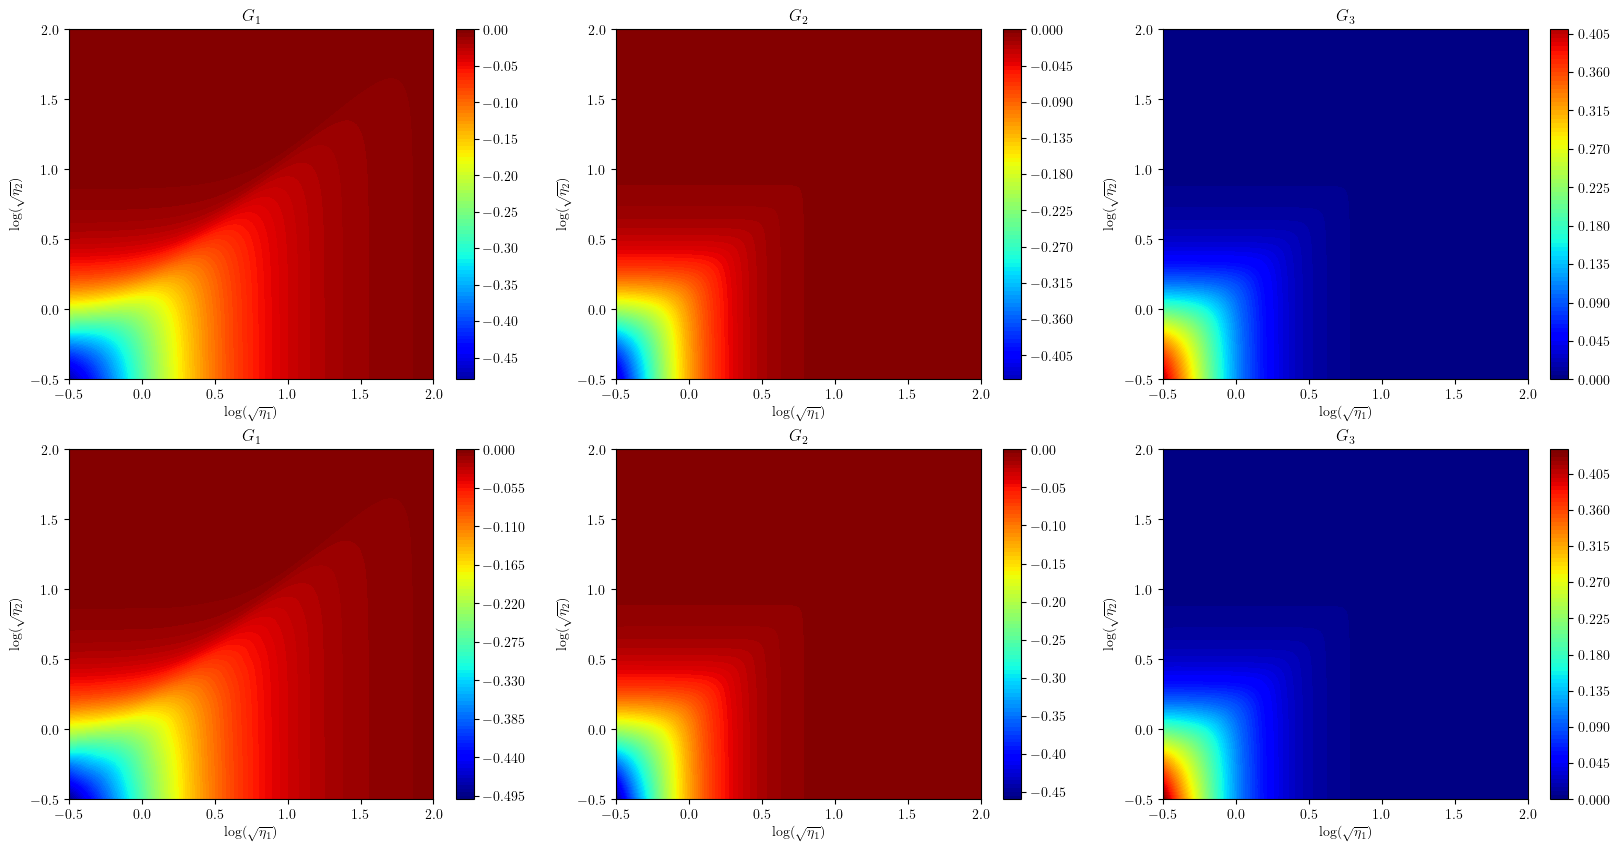

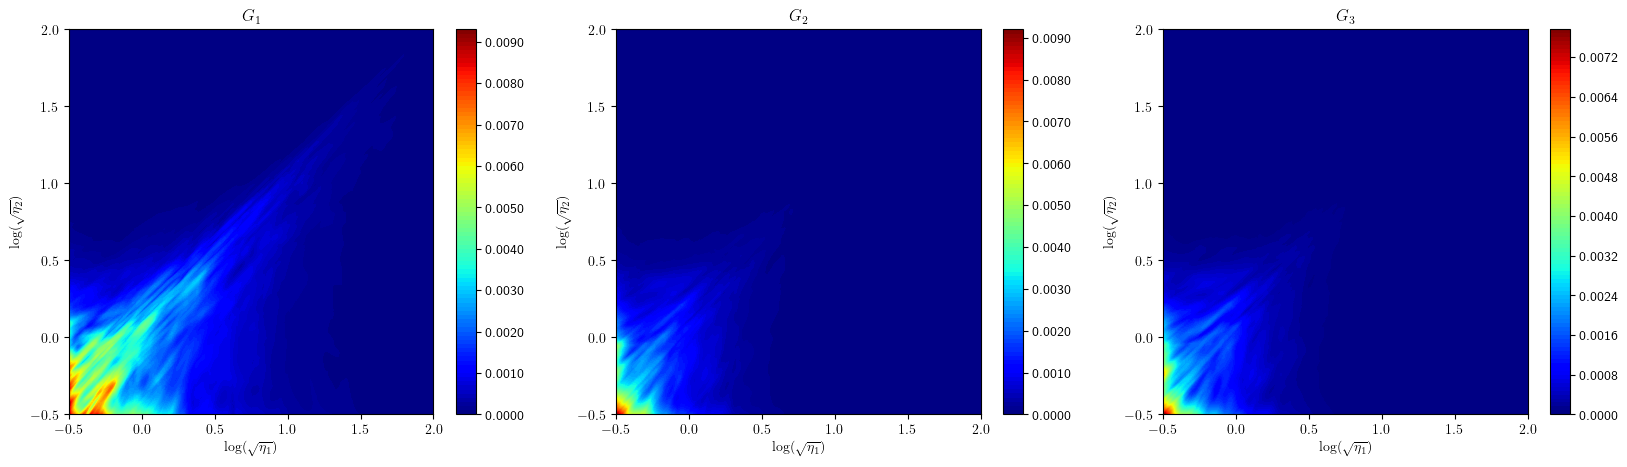

In [12]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s.T.reshape(3, dim, dim)

etas = x_scaler.transform(etas)

preds = np.zeros((num_members, len(etas), 3))

for i in range(num_members):
    pred = ensemble[i].predict(etas.astype(np.float32))
    preds[i] = y_scaler.inverse_transform(pred)


pred = preds.mean(axis=0)

std = preds.std(axis=0)

np.savetxt('data/Ensemble/Pred_Mean.csv', pred, delimiter=',')
np.savetxt('data/Ensemble/Pred_Std.csv', std, delimiter=',')

print(torch.mean(torch.abs(torch.tensor(target) - pred.T.reshape(3, dim, dim))))

plot_heat_map_compare(x_grid, y_grid, target, pred.T.reshape(3, dim, dim), 'Algebraic', 'Ensemble', sup_title=False)

plot_heat_map_3D(x_grid, y_grid, std.T.reshape(3, dim, dim), "Ensemble Standard Deviation", sup_title=False)

## Visualizing Functions

In [17]:
predictions = []
for member in ensemble:
    predictions.append(y_scaler.inverse_transform(member.predict(x_vis)).reshape(1,-1))

predictions.append(y_scaler.inverse_transform(y_vis.cpu().numpy()).reshape(1,-1))

vis_outputs = np.concatenate(predictions, axis=0)

Calculating PHATE...
  Running PHATE on 21 observations and 2400 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.01 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating optimal t...
    Automatically selected t = 10
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.02 seconds.


/home/codygrogan/.local/lib/python3.12/site-packages/graphtools/graphs.py:122: UserWarning: Building a kNNGraph on data of shape (21, 2400) is expensive. Consider setting n_pca.
  warnings.warn(


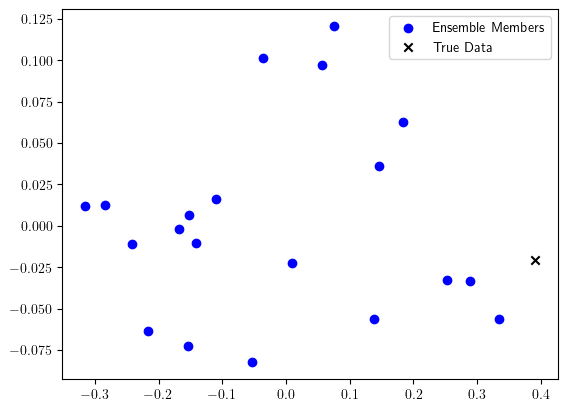

In [19]:
from phate import PHATE

phate = PHATE(n_components=2, n_jobs=4)

embedding = phate.fit_transform(vis_outputs)

plt.scatter(embedding[:-1, 0], embedding[:-1, 1], c='b', label='Ensemble Members')

plt.scatter(embedding[-1, 0], embedding[-1, 1], c='black', marker='x', label='True Data')

plt.legend()
plt.show()